# Gaussian mixure variational autoencoder

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import tensorflow as tf
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)
from keras.preprocessing.image import ImageDataGenerator

import os, sys
import cv2
import glob

# os.chdir(os.path.dirname(os.getcwd()))
#CURRENT_DIR = os.path.dirname(os.path.abspath(__file__))
sys.path.append('Alg_GMVAE/') # Consider also the parent directory for the module lookup

from utils.dataset import Dataset
from bunch import Bunch
from utils.args_processing import get_args, get_config_and_flags
from utils.logger import Logger
from utils.utils import save_img
from keras.utils. generic_utils import Progbar

import matplotlib.pyplot as plt
import numpy as np
from numpy import ones
from numpy.random import randn
from numpy.random import randint

import utils.utils as utils
import utils.constants as const 
plt.close("all")

#from GMVAE_model import GMVAE_model

Using TensorFlow backend.


In [2]:
# create the experiments dirs
summary_dir = 'logdir/'
checkpoint_dir = 'modeldir/'
results_dir = 'results/'
utils.create_dirs([summary_dir, checkpoint_dir, results_dir])

0

## Dataset

In [3]:
def normalize_data(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return (img.astype(np.float32) - 127.5) / 127.5

# load tomato images
def load_real_samples():
    # folder where data is placed
    BASE_FOLDER = '/floyd/input/tomato_dataset/training'
    BASE_FOLDER_TEST = '/floyd/input/tomato_dataset/testing/'
    
    trainAug = ImageDataGenerator(
            rescale=1 / 255.0,
            rotation_range=20,
            zoom_range=0.05,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.05,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode="nearest",
            validation_split=0.2)
            #preprocessing_function=normalize_data)
        
    testAug = ImageDataGenerator(rescale=1 / 255.0)
    
    trainGen = trainAug.flow_from_directory(
            BASE_FOLDER,
            class_mode="input",
            target_size=(48, 48),
            color_mode="rgb",
            shuffle=True,
            batch_size=32,
            subset='training')
    
    valGen = trainAug.flow_from_directory(
            BASE_FOLDER,
            class_mode="input",
            target_size=(48, 48),
            color_mode="rgb",
            shuffle=True,
            batch_size=32,
            subset='validation')
    
    testGen = testAug.flow_from_directory(
            BASE_FOLDER_TEST,
            class_mode="input",
            target_size=(48, 48),
            color_mode="rgb",
            shuffle=False,
            batch_size=32)
    
    return trainGen, valGen, testGen

In [4]:
def get_coordinates(filename):
  filename_without_format = filename[:-4]
  filename_list = filename_without_format.split('_')
  coordinates_list = filename_list[-1].split('x')
  for item in range(len(coordinates_list)):
    coordinates_list[item] = int(coordinates_list[item])
  return coordinates_list

def load_test_data():
    # folder where data is placed
    #BASE_FOLDER = '/floyd/input/tomato_dataset/testing/2019-09-19_06_47_32/'
    BASE_FOLDER = '/floyd/input/tomato_dataset/testing/2019-09-21_02_21_55/' #healty
    img_list = glob.glob(BASE_FOLDER + '*.png')
    images = list()
    coordinates = list()
    
    for img_path in img_list:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (48, 48), interpolation = cv2.INTER_NEAREST)
        #img = (img.astype(np.float32) - 127.5) / 127.5
        img = img / 255
        images.append(img)
        position = get_coordinates(img_path)
        coordinates.append(position)
        
    print('Found ' + str(len(images)) + ' images for test.')
    return (np.asarray(images), coordinates)

In [5]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # get batch
    X, _ = dataset.next()
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images
    X = X[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [6]:
# select real samples
def generate_test_samples(X, n_samples):
    # choose random instances
    ix = randint(0, X.shape[0], n_samples)
    # select images
    X = X[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [7]:
def get_eval_samples(dataset_path, regular_data=True):
    img_list = glob.glob(dataset_path + '*.png')
    images = list()
    
    if (regular_data):
        labels = np.zeros(len(img_list))
    else:
        labels = np.ones(len(img_list))
    
    for img_path in img_list:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (48, 48), interpolation = cv2.INTER_NEAREST)
        img = (img.astype(np.float32) - 127.5) / 127.5
        images.append(img)
        
    print('Found ' + str(len(images)) + ' images for test.')
    print('Labels:', str(len(labels)))
    return (images, labels)

In [8]:
# load image data
dataset, val_dataset, test_dataset = load_real_samples()
test_ano_dataset, test_coordinates = load_test_data()

Found 153360 images belonging to 240 classes.
Found 38160 images belonging to 240 classes.
Found 2394 images belonging to 3 classes.
Found 798 images for test.


## Model

In [9]:
network_params = Bunch()
network_params.input_height = 48
network_params.input_width = 48
network_params.input_nchannels = 3

network_params.hidden_dim =  64
network_params.z_dim =  8
network_params.w_dim =  2
network_params.K =  8
network_params.num_layers =  2

In [10]:
from GMVAE_model import GMVAEModel
vae_model = GMVAEModel(network_params,sigma=0.001, sigma_act=utils.softplus_bias,
                       transfer_fct=tf.nn.relu,learning_rate=2e-4,
                       kinit=tf.contrib.layers.xavier_initializer(),
                       batch_size=32, drop_rate=0.3, 
                       epochs=20, checkpoint_dir=checkpoint_dir, 
                       summary_dir=summary_dir, result_dir=results_dir, 
                       restore=0, model_type=3)
print('\nNumber of trainable paramters', vae_model.trainable_count)


[*] Defining Q(z|x)...
[*] Layer ( Qz_x/conv_1/Relu:0 ) output shape: [32, 24, 24, 32]
[*] Layer ( Qz_x/conv_2/Relu:0 ) output shape: [32, 12, 12, 64]
[*] Layer ( Qz_x/conv_3/Relu:0 ) output shape: [32, 6, 6, 64]

[*] Layer ( Qz_x/dense_1/Relu:0 ) output shape: [32, 16]

[*] Layer ( Qz_x/mean/dense_1/BiasAdd:0 ) output shape: [32, 8]

[*] Layer ( Qz_x/var/dense_1/Softplus:0 ) output shape: [32, 8]

[*] Reparameterization trick...

[*] Defining Q(w|x)...
[*] Layer ( Qw_x/conv_1/Relu:0 ) output shape: [32, 24, 24, 32]
[*] Layer ( Qw_x/conv_2/Relu:0 ) output shape: [32, 12, 12, 64]
[*] Layer ( Qw_x/conv_3/Relu:0 ) output shape: [32, 6, 6, 64]

[*] Layer ( Qw_x/dense_1/Relu:0 ) output shape: [32, 4]

[*] Layer ( Qw_x/mean/dense_1/BiasAdd:0 ) output shape: [32, 2]

[*] Layer ( Qw_x/var/dense_1/Softplus:0 ) output shape: [32, 2]

[*] Reparameterization trick...

[*] Defining P(y|w,z)...

[*] Layer ( Py_wz/dense_1/Relu:0 ) output shape: [32, 64]
[*] Layer ( Py_wz/dense_1_dropout/Identity:0 )

## Train

In [17]:
vae_model.train(dataset, val_dataset, enable_es=1)

Model does NOT exist
Initizalizing Variables ...
EPOCH:  0

TRAIN | Loss: 67241.41 | Recons: 67182.65 | CP: 56.822083 | KL_w: 0.077418655 | KL_y: 1.861645 | L2_loss: 633.5318
VALID | Loss: 67196.76 | Recons: 67143.36 | CP: 52.219185 | KL_w: 0.071807526 | KL_y: 1.1059451 | L2_loss: 751.62823
Saving model...
Model saved
EPOCH:  1

TRAIN | Loss: 51684.97 | Recons: 51635.574 | CP: 48.432228 | KL_w: 0.035082094 | KL_y: 0.9247794 | L2_loss: 723.5993
VALID | Loss: 66177.945 | Recons: 66126.516 | CP: 50.08482 | KL_w: 0.009022563 | KL_y: 1.3324543 | L2_loss: 707.2522
Saving model...
Model saved
EPOCH:  2

TRAIN | Loss: 50657.758 | Recons: 50610.953 | CP: 45.71394 | KL_w: 0.002391073 | KL_y: 1.088097 | L2_loss: 705.3204
VALID | Loss: 65577.586 | Recons: 65529.0 | CP: 47.295055 | KL_w: 0.00023341831 | KL_y: 1.2959245 | L2_loss: 707.2538
Saving model...
Model saved
EPOCH:  3

TRAIN | Loss: 50112.773 | Recons: 50066.92 | CP: 44.68435 | KL_w: 9.270083e-05 | KL_y: 1.165521 | L2_loss: 716.6831
VALID |

## Evaluation

Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21


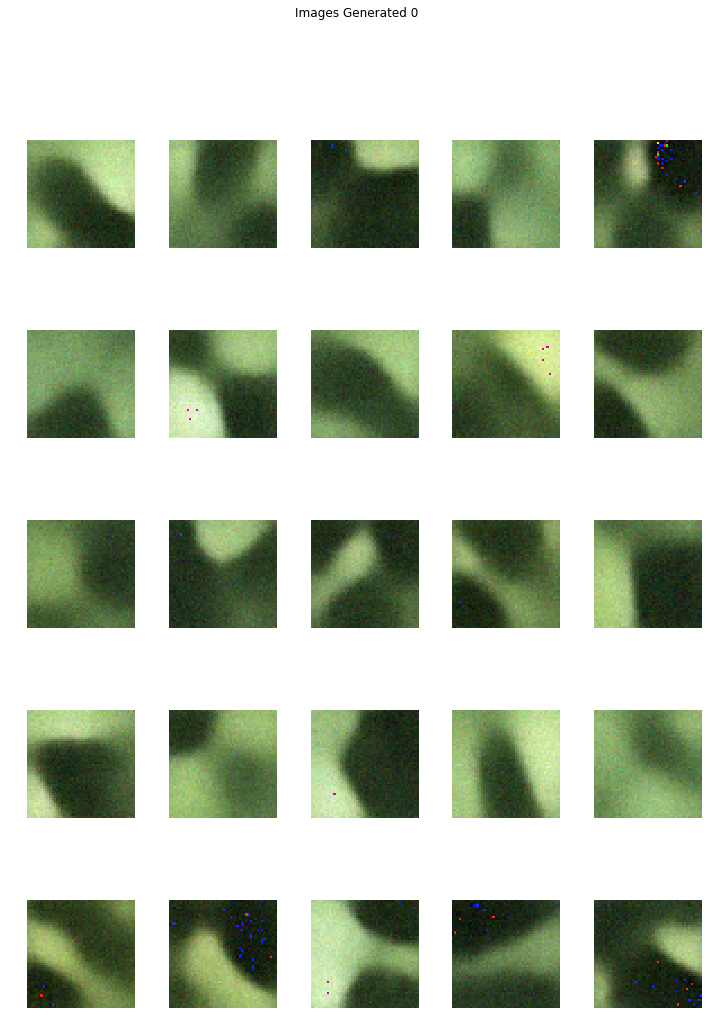

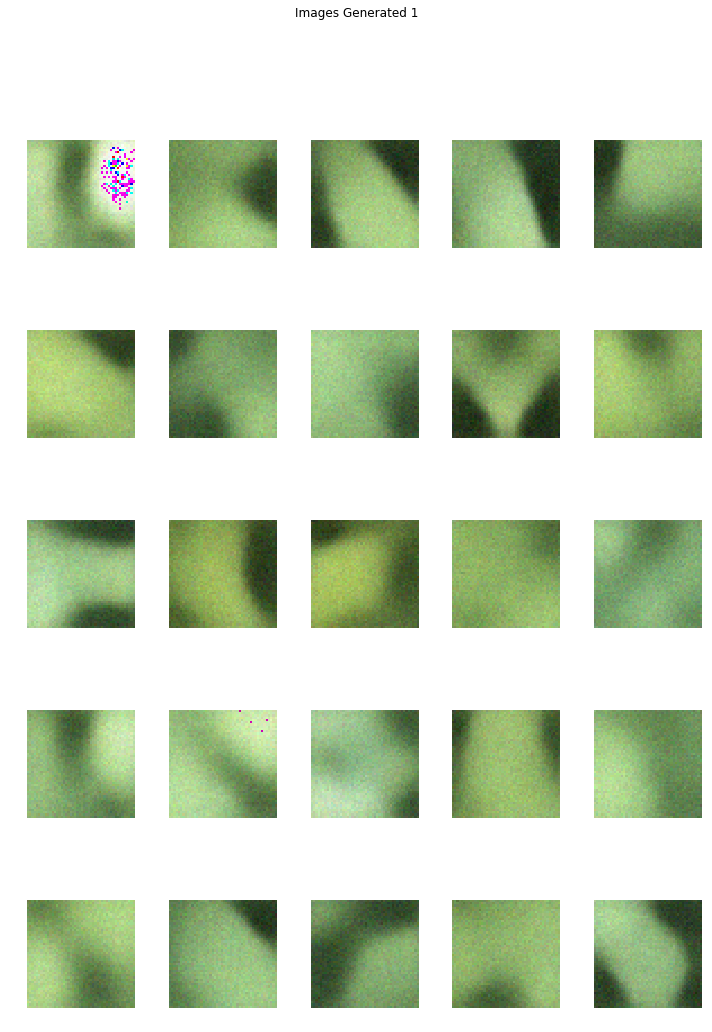

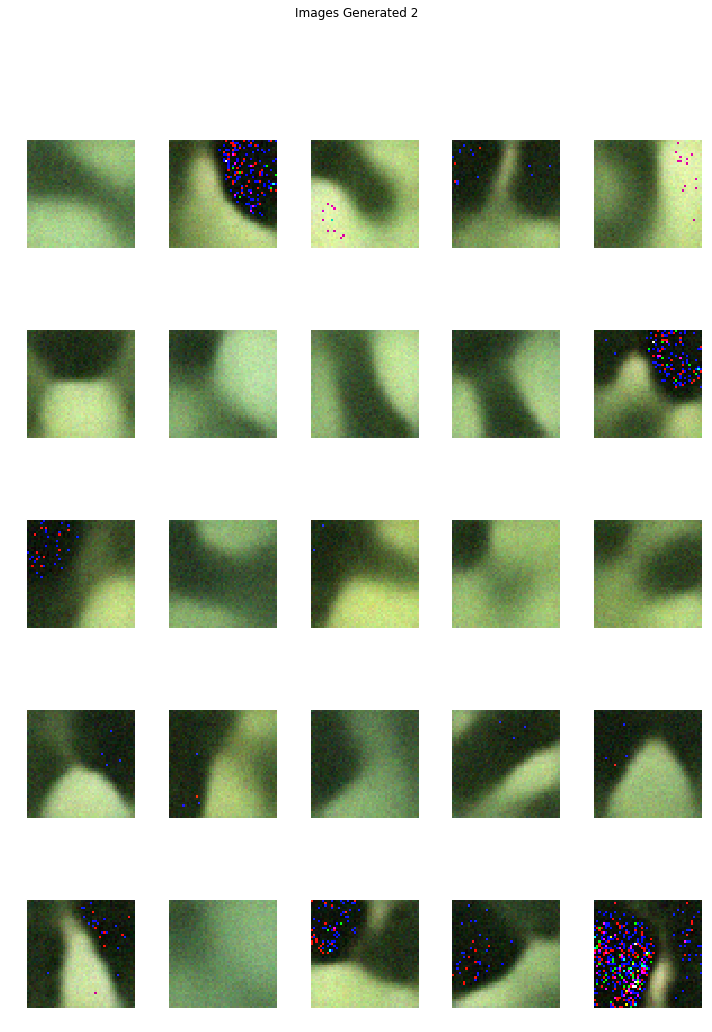

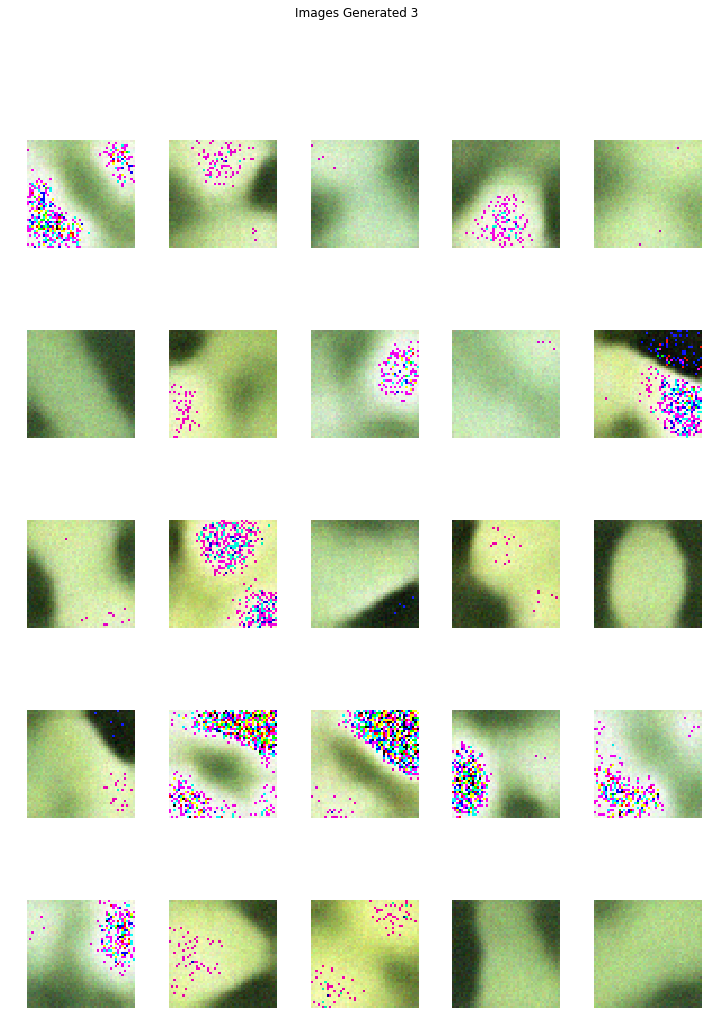

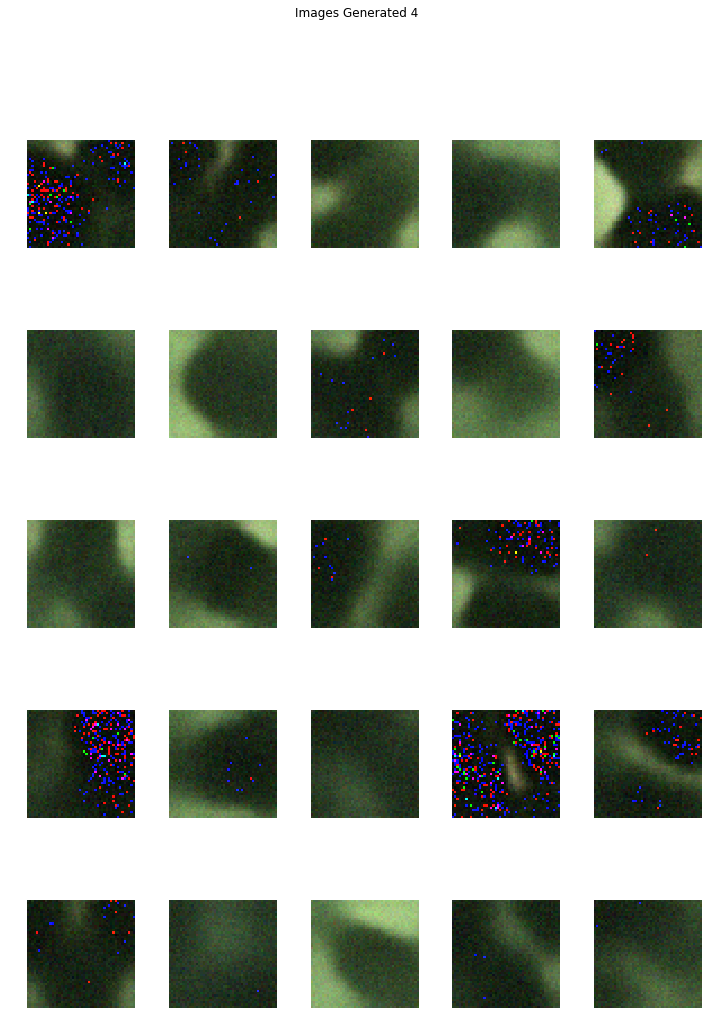

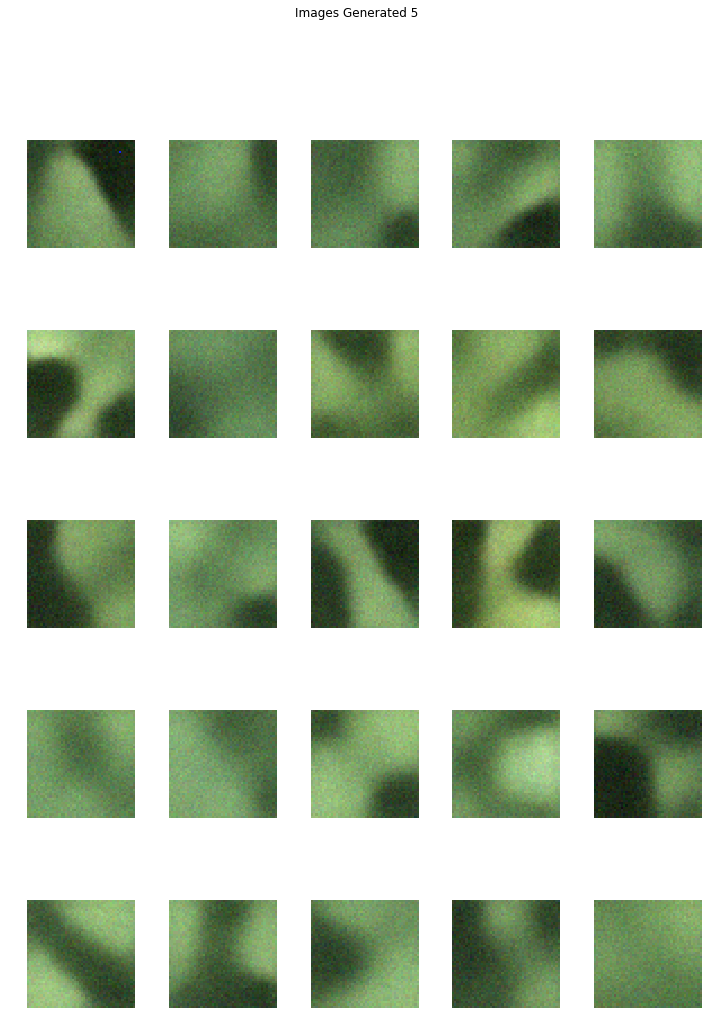

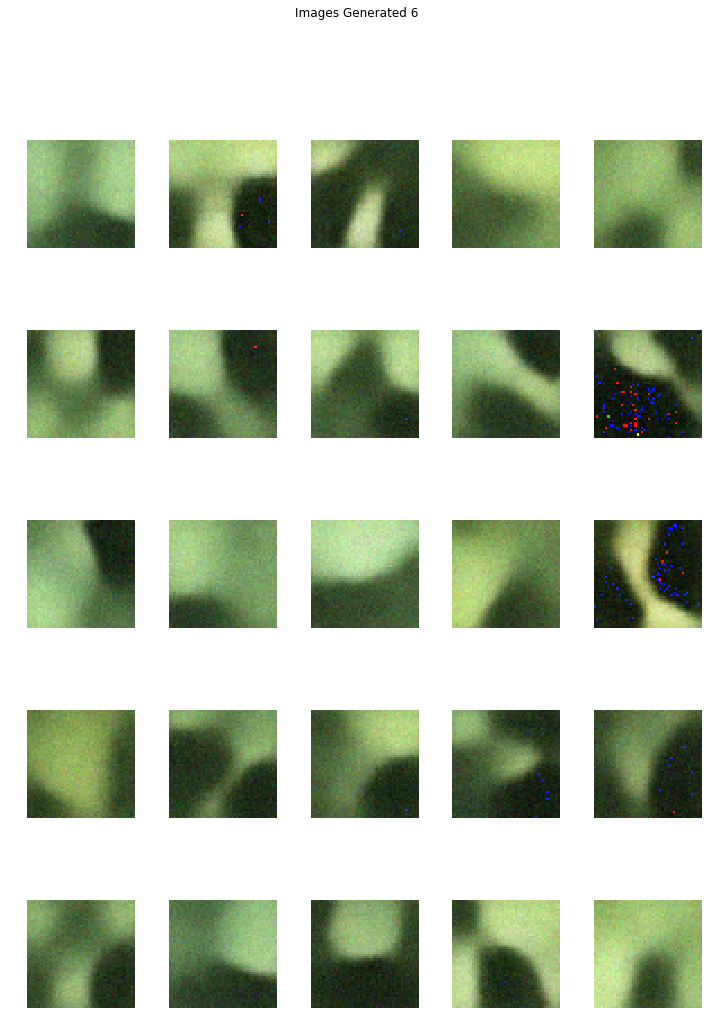

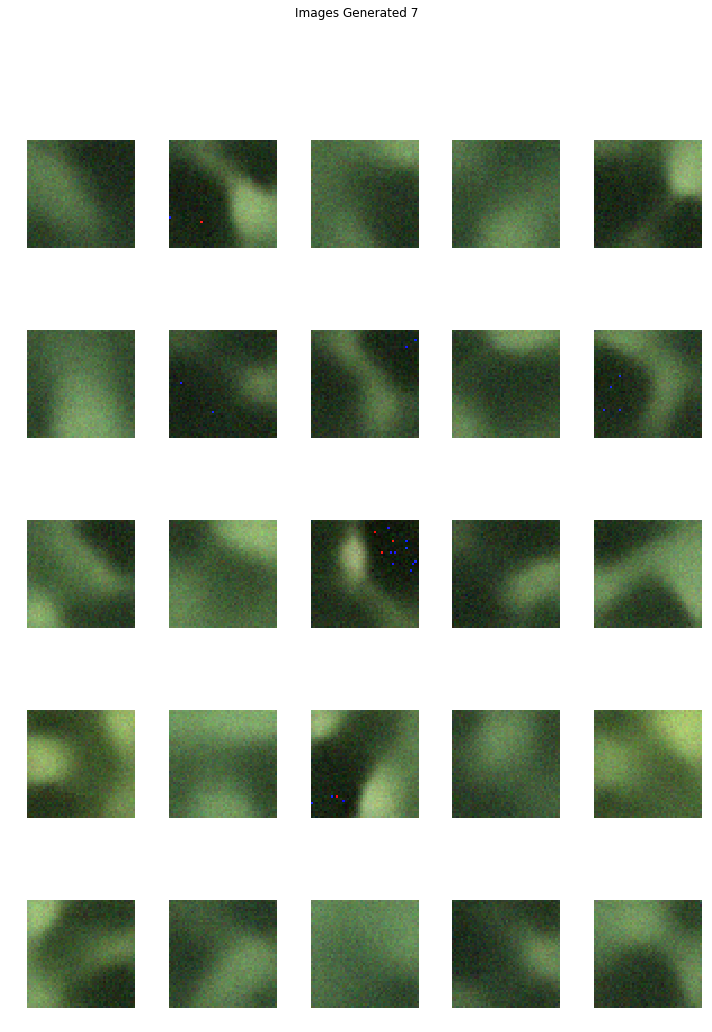

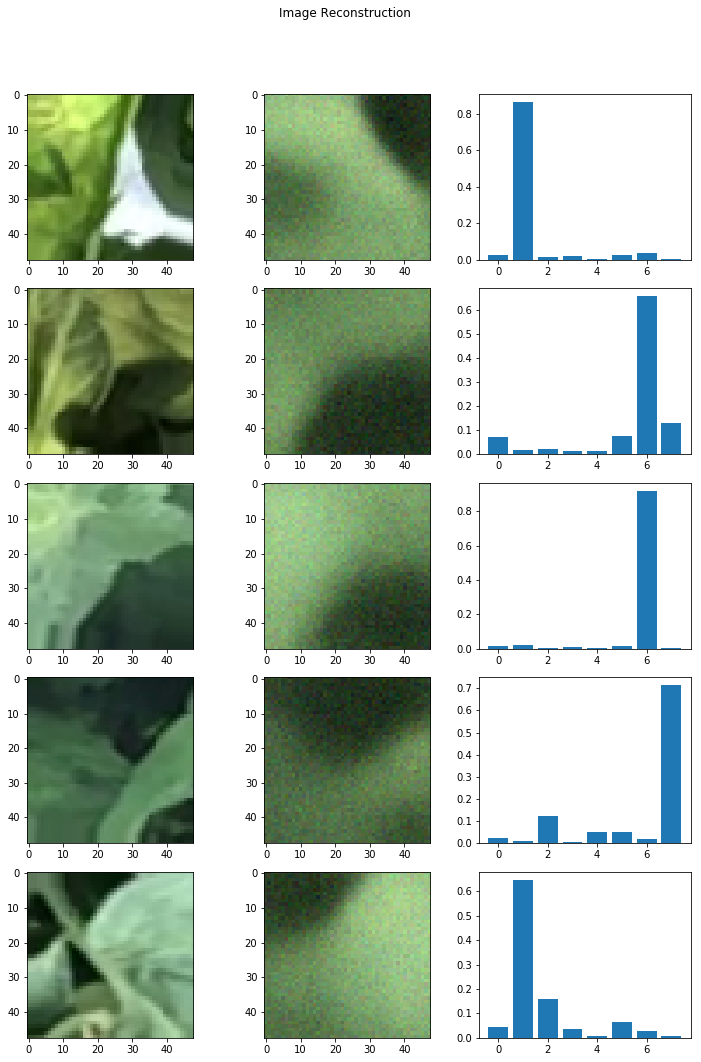

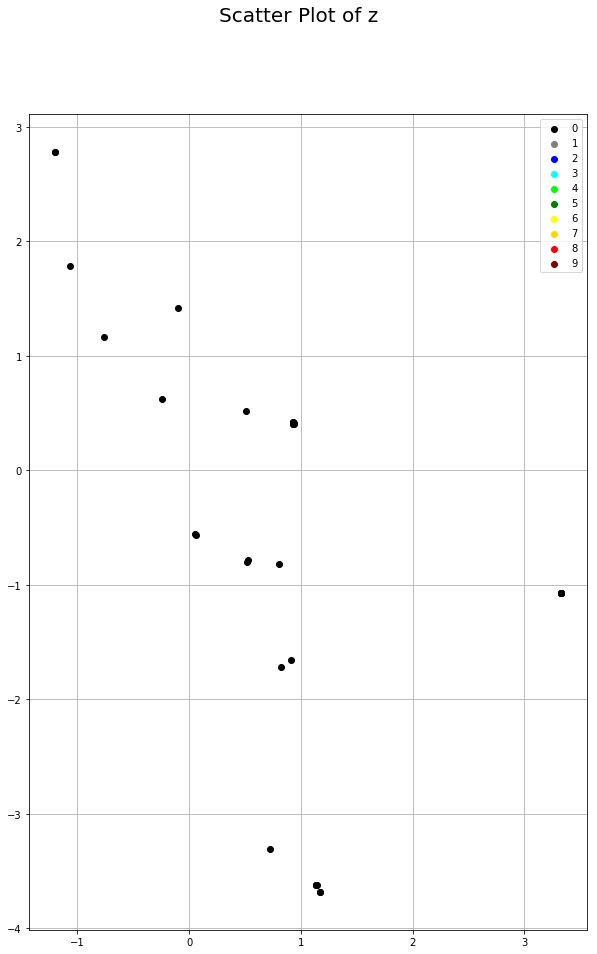

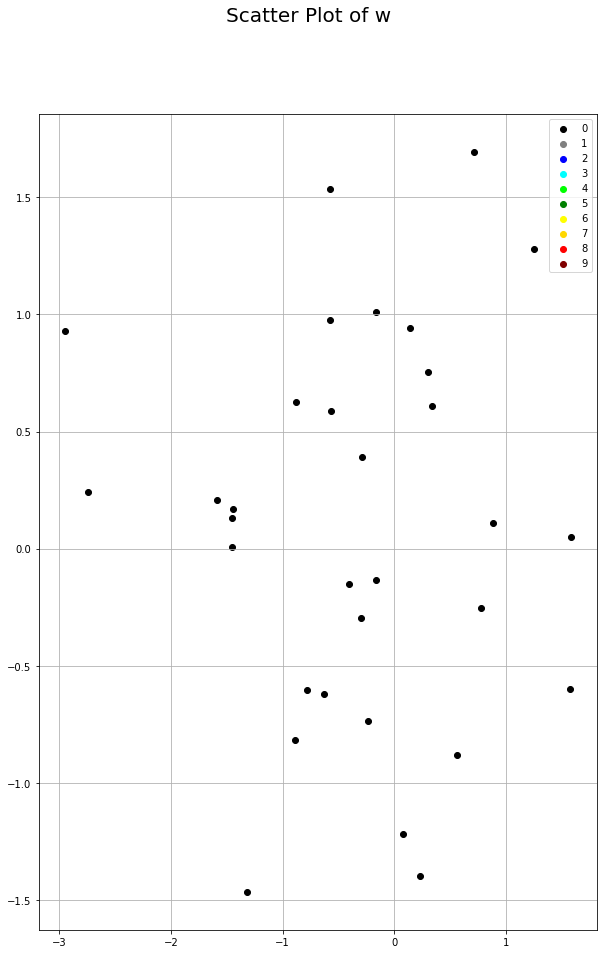

In [16]:
from GMVAE_visualize import GMVAEVisualize
visualize = GMVAEVisualize('GMVAE', results_dir, (10, 15))

data_test, _ = generate_real_samples(dataset, 32)
x_samples, z_samples, w_samples = vae_model.generate_samples(data_test, num_batches=2)    
visualize.samples(x_samples, z_samples, w_samples)
    
x_input, x_labels, x_recons, z_recons, w_recons, y_recons = vae_model.reconstruct_input(data_test)
visualize.recons(x_input, x_labels, x_recons, z_recons, w_recons, y_recons)

Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21


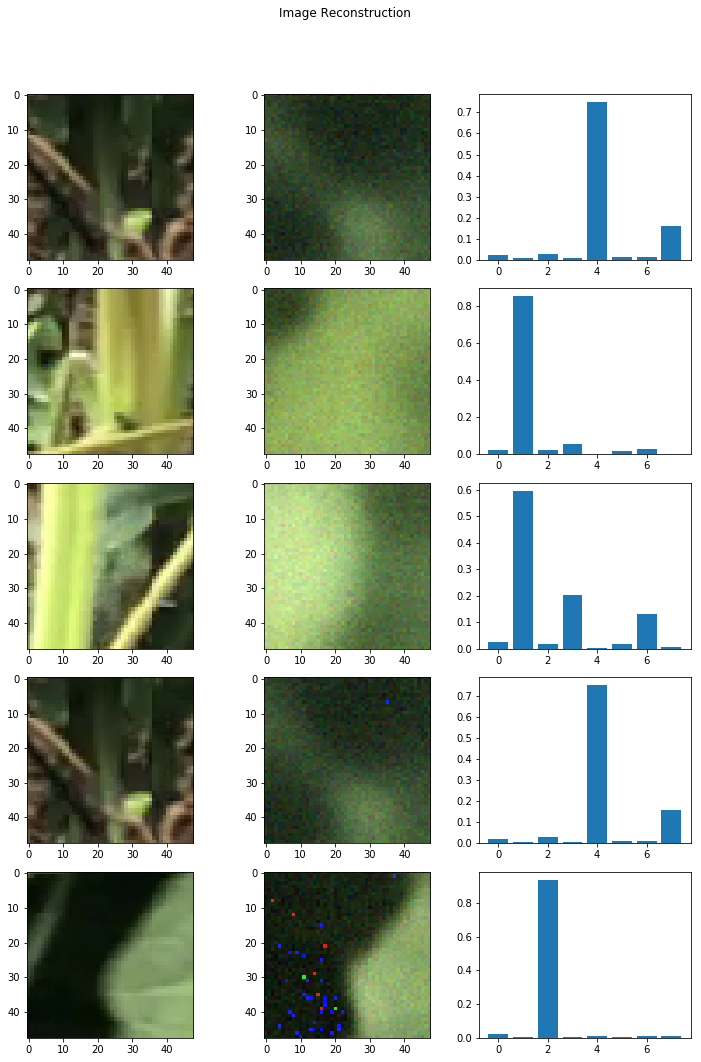

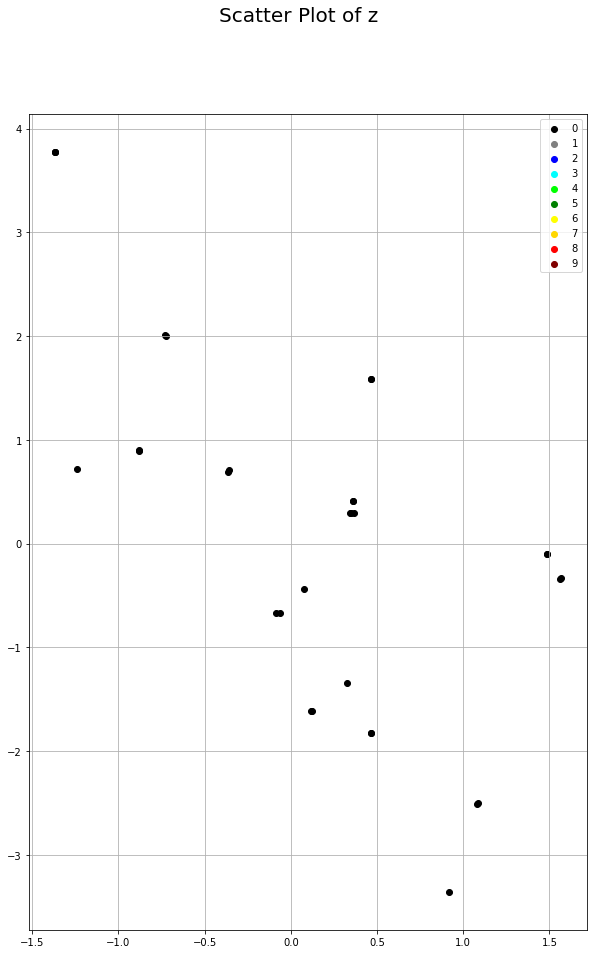

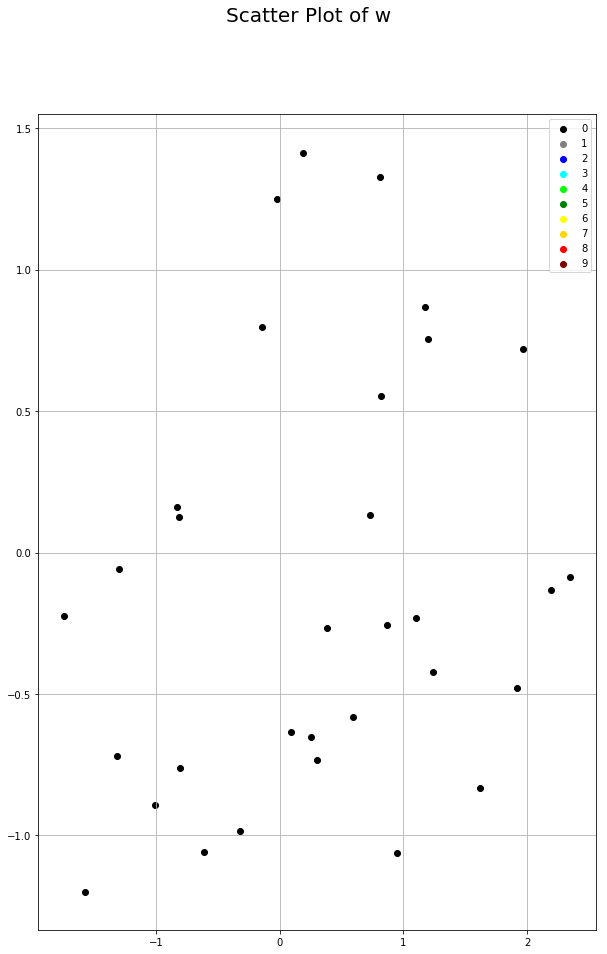

In [20]:
data_test, _ = generate_real_samples(test_dataset, 32)
x_input, x_labels, x_recons, z_recons, w_recons, y_recons = vae_model.reconstruct_input(data_test)
visualize.recons(x_input, x_labels, x_recons, z_recons, w_recons, y_recons)

## Anomaly detection

In [11]:
def anomaly_evaluation(test_img):
    test_samples = np.zeros([32,48,48,3])
    for i, _ in enumerate(test_samples):
        test_samples[i] = test_img

    x_input, x_labels, x_recons, z_recons, w_recons, y_recons = vae_model.reconstruct_input(test_samples)

    # anomaly area, 255 normalization
    np_residual = test_img.reshape(48,48,3) - x_recons[0].reshape(48,48,3)
    np_residual = (np_residual + 2)/4
    np_residual = (255*np_residual).astype(np.uint8)
    original_x = (test_img.reshape(48,48,3)*255).astype(np.uint8)
    residual_color = cv2.applyColorMap(np_residual, cv2.COLORMAP_JET)
    show = cv2.addWeighted(original_x, 0.3, residual_color, 0.7, 0.)

    similar_img = x_recons[0]
    similar_img = similar_img*255
    similar_img = similar_img.astype(np.uint8)
    similar_img = cv2.cvtColor(similar_img, cv2.COLOR_BGR2RGB)
    
    return (similar_img, show)

def anomaly_plot(test_img):
    start = cv2.getTickCount()
    similar_img, anomaly = anomaly_evaluation(test_img)
    time = (cv2.getTickCount() - start) / cv2.getTickFrequency() * 1000
    print('time:', time)
    
    test_img = test_img*255
    test_img = test_img.astype(np.uint8)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    ### plt view
    plt.figure(num=0, figsize=(4, 4))
    plt.title('Sample image')
    plt.imshow(test_img, cmap=plt.cm.gray)
    plt.show()

    plt.figure(num=0, figsize=(4, 4))
    plt.title('Reconstructed image')
    plt.imshow(similar_img, cmap=plt.cm.gray)
    plt.show()

    plt.figure(num=0, figsize=(4, 4))
    plt.title('Anomaly detection')
    plt.imshow(anomaly, cmap=plt.cm.gray)
    plt.show()

Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 24896.742 | Recons: 24861.254 | CP: 34.657974 | KL_w: 1.0362128e-06 | KL_y: 0.8305682 | L2_loss: 1481.7683
time: 1383.044483


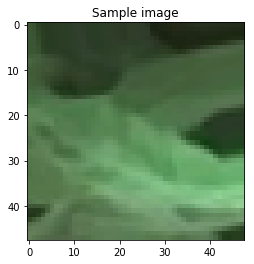

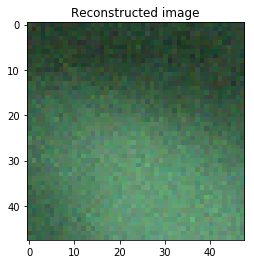

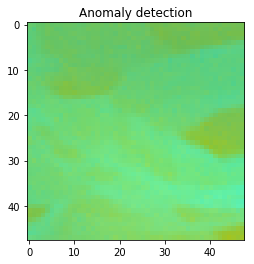

In [13]:
test_images, _ = generate_real_samples(dataset, 32)
anomaly_plot(test_images[0])

Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 79915.5 | Recons: 79876.234 | CP: 37.944412 | KL_w: 1.0362128e-06 | KL_y: 1.3275219 | L2_loss: 1481.7683


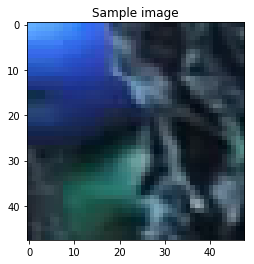

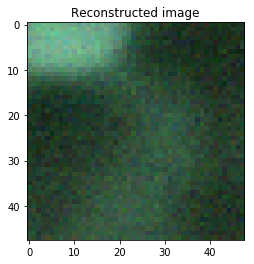

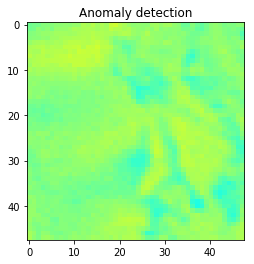

In [61]:
test_images, _ = generate_real_samples(test_dataset, 32)
anomaly_plot(test_images[0])

In [40]:
def combine_images(generated_images, coordinates, width = 38, height = 21, orig_width = 50, orig_height = 50):
    num = generated_images.shape[0]
    shape = generated_images.shape[1:4]
    image = np.zeros((height*orig_height, width*orig_width, shape[2]),
                     dtype=generated_images.dtype)
    
    for index, img in enumerate(generated_images):
        position = coordinates[index]
        img = img = cv2.resize(img, (orig_width, orig_height), interpolation = cv2.INTER_NEAREST)
        i1 = position[0]
        i2 = i1 + orig_width
        j1 = position[1]
        j2 = j1 + orig_height
        image[i1:i2, j1:j2,:] = img[:, :, :]
    return image

def evaluate_roi(roi):
    anomalies = np.zeros(test_ano_dataset.shape)
    for i, image in enumerate(test_ano_dataset):
        position = test_coordinates[i]
        if (((roi[0] + roi[2]) > position[1] >= roi[0]) and ((roi[1] + roi[3]) > position[0] >= roi[1])):
            _, anomaly = anomaly_evaluation(image)
            anomalies[i] = cv2.cvtColor(anomaly, cv2.COLOR_BGR2RGB)
        else:
            anomalies[i] = test_ano_dataset[i]
            anomalies[i] = anomalies[i]*255
            anomalies[i] = anomalies[i].astype(np.uint8)

    anomaly_img = combine_images(anomalies, test_coordinates)
    anomaly_img = anomaly_img.astype(np.uint8)
    anomaly_img = cv2.cvtColor(anomaly_img, cv2.COLOR_BGR2RGB)
    return anomaly_img

Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 74833.55 | Recons: 74799.805 | CP: 32.077297 | KL_w: 1.0362128e-06 | KL_y: 1.6583961 | L2_loss: 1481.7683
Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 92406.9 | Recons: 92369.78 | CP: 35.96473 | KL_w: 1.0362128e-06 | KL_y: 1.1568806 | L2_loss: 1481.7683
Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 91054.04 | Recons: 91023.22 | CP: 29.214577 | KL_w: 1.0362128e-06 | KL_y: 1.6110809 | L2_loss: 1481.7683
Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 136081.22 | Recons: 136043.08 | CP: 37.236584 | KL_w: 1.0362128e-06 | KL_y

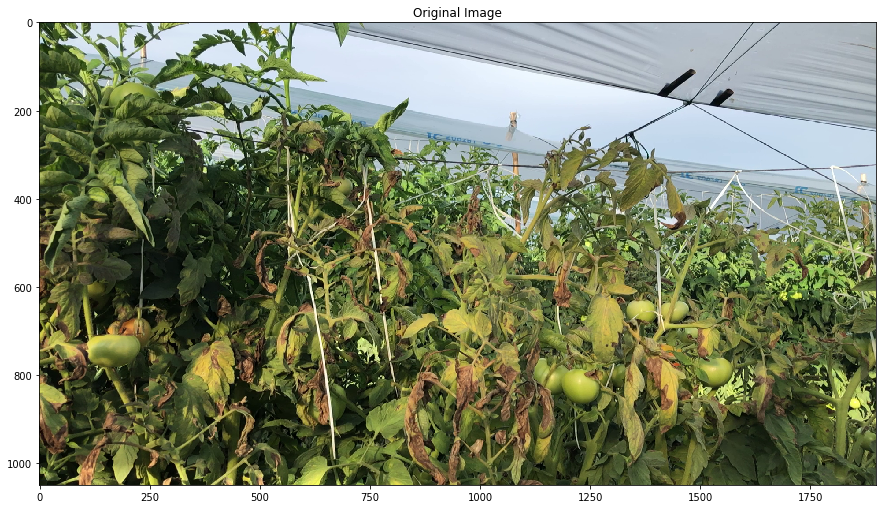

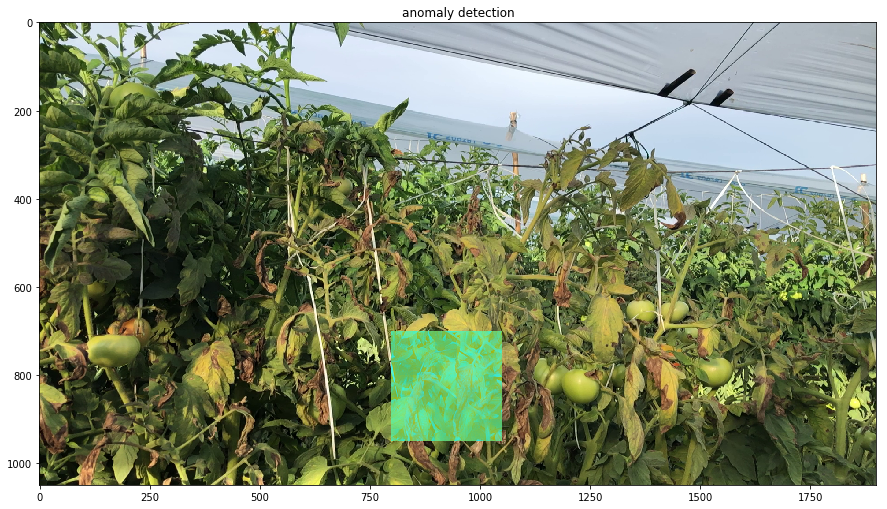

In [49]:
img = combine_images(test_ano_dataset, test_coordinates)
img = img*255
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

roi = (800, 700, 250, 250) # x, y, w, h
anomaly_img = evaluate_roi(roi)

plt.figure(num=0, figsize=(15, 15))
plt.title('Original Image')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

plt.figure(num=0, figsize=(15, 15))
plt.title('anomaly detection')
plt.imshow(anomaly_img)
plt.show()

Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 48197.812 | Recons: 48164.83 | CP: 31.249325 | KL_w: 1.0362128e-06 | KL_y: 1.732446 | L2_loss: 1481.7683
Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 45718.6 | Recons: 45681.18 | CP: 36.666306 | KL_w: 1.0362128e-06 | KL_y: 0.7526495 | L2_loss: 1481.7683
Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 62643.055 | Recons: 62605.453 | CP: 36.40534 | KL_w: 1.0362128e-06 | KL_y: 1.1999602 | L2_loss: 1481.7683
Loading model checkpoint modeldir/-100653 ...

INFO:tensorflow:Restoring parameters from modeldir/-100653
Model loaded
EPOCHS trained:  21
VALID | Loss: 50649.42 | Recons: 50615.78 | CP: 32.129204 | KL_w: 1.0362128e-06 | KL_y:

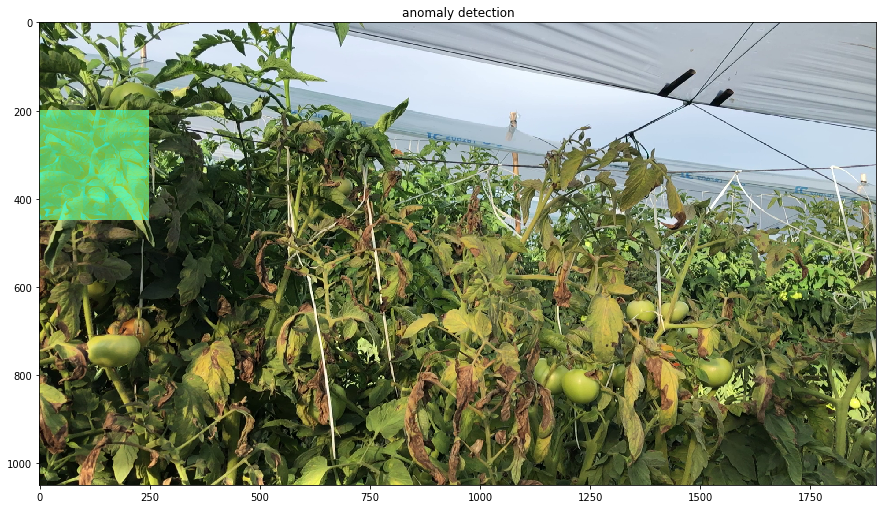

In [50]:
roi = (0, 200, 250, 250) # x, y, w, h
anomaly_img = evaluate_roi(roi)

plt.figure(num=0, figsize=(15, 15))
plt.title('anomaly detection')
plt.imshow(anomaly_img)
plt.show()

In [11]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [12]:
def eval_anomaly(test_img, model, anomaly_treshold = 4000):
    test_samples = np.zeros([32,48,48,3])
    for i, _ in enumerate(test_samples):
        test_samples[i] = test_img
    
    x_input, x_labels, x_recons, z_recons, w_recons, y_recons = model.reconstruct_input(test_samples)
    original_x = ((test_img.reshape(48,48,3)*127.5)+127.5).astype(np.uint8)
    similar_img = x_recons[0]
    similar_img = (similar_img*127.5)+127.5
    similar_img = similar_img.astype(np.uint8)
    similar_img = cv2.cvtColor(similar_img, cv2.COLOR_BGR2RGB)
    
    score = mse(original_x, similar_img)
    
    has_anomaly = 0
    if (score > anomaly_treshold):
        has_anomaly = 1
    
    return (score, has_anomaly)

In [13]:
regular_data, reg_labels = get_eval_samples('/floyd/input/tomato_dataset/testing/2019-09-21_02_21_55/')
#regular_data, reg_labels = get_eval_samples('/floyd/input/tomato_dataset/evaluation/2019-09-19_06_47_32/regular/')

regular_data = np.asarray(regular_data)
# choose random instances
ix = randint(0, regular_data.shape[0], 479)
# select images
regular_data = regular_data[ix]
reg_labels = reg_labels[ix]
print(regular_data.shape)
print(reg_labels.shape)

Found 798 images for test.
Labels: 798
(479, 48, 48, 3)
(479,)


In [14]:
ano_data, ano_labels = get_eval_samples('/floyd/input/tomato_dataset/evaluation/2019-09-19_06_47_32/anomalies/', regular_data=False)

Found 479 images for test.
Labels: 479


In [15]:
labels = np.concatenate((reg_labels, ano_labels))
reg_res_labels = np.zeros(len(reg_labels))
ano_res_labels = np.zeros(len(ano_labels))
res_labels = np.zeros(len(labels))

In [27]:
regular_scores, ano_scores = vae_model.reconstruct_eval(regular_data, ano_data)

957/958 [============================>.] - ETA: 0s - score: 12249.6548

Healthy mean: 15162.199554917652
Healty std: 7597.285453067023
Anomalies mean: 9357.271766628974
Anomalies std: 6071.700696123492


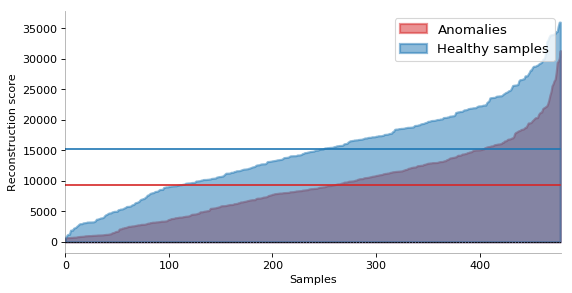

In [30]:
print('Healthy mean:', np.mean(regular_scores))
print('Healty std:', np.std(regular_scores))
print('Anomalies mean:', np.mean(ano_scores))
print('Anomalies std:', np.std(ano_scores))

reg_mean = np.ones(len(regular_scores)) * np.mean(regular_scores)
ano_mean = np.ones(len(ano_scores)) * np.mean(ano_scores)

regular_plot = np.sort(regular_scores)
ano_plot = np.sort(ano_scores)

x = np.arange(len(regular_plot))
y1 = ano_plot
y2 = regular_plot
mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive'] 

# Draw Plot 
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi= 80)
ax.fill_between(x, y1=y1, y2=0, label='Anomalies', alpha=0.5, color=mycolors[0], linewidth=2)
ax.fill_between(x, y1=y2, y2=0, label='Healthy samples', alpha=0.5, color=mycolors[1], linewidth=2)

# Decorations
ax.legend(loc='best', fontsize=12)
ax.set(xlim=[0, 479])

# Draw Tick lines  
for y in np.arange(2.5, 30.0, 2.5):    
    plt.hlines(y, xmin=0, xmax=len(x), colors='black', alpha=0.3, linestyles="--", lw=0.5)

# Lighten borders
plt.gca().spines["top"].set_alpha(0)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(0)
plt.gca().spines["left"].set_alpha(.3)

plt.plot(reg_mean, color=mycolors[1])
plt.plot(ano_mean, color=mycolors[0])
plt.ylabel("Reconstruction score")
plt.xlabel("Samples")

plt.show()